0. Check Anomaly Column

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Load the training dataset
train_data = pd.read_csv("train/TRAIN_B.csv")

# Convert the timestamp column to a datetime object for easier time-based analysis
# train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'], format='%y/%m/%d %H:%M')

# Preview the dataset
print("Dataset Overview")
print(train_data.head())
print("\nSummary Statistics")
print(train_data.describe())

# Check for missing values
print("\nMissing Values")
print(train_data.isnull().sum())
if train_data.isnull().sum().sum() == 0:
    print("No missing values found.")

# Check if 'anomaly' is flagged correctly
# Sum all P1_flag to P26_flag columns and compare to 'anomaly'
sensor_flags = train_data.filter(regex='P\d+_flag').astype(bool)
train_data['sensor_flags_sum'] = sensor_flags.sum(axis=1).astype(bool)
anomaly_flag_validation = (train_data['anomaly'] == 1) & (train_data['sensor_flags_sum'] == 0)

# Print validation results
if anomaly_flag_validation.any():
    print("Warning: Some anomalies are flagged incorrectly (anomaly=1, but no sensor flags are set).")
else:
    print("Validation Passed: 'anomaly' flag is set correctly based on sensor flags.")

# Drop the helper column after validation
train_data.drop('sensor_flags_sum', axis=1, inplace=True)


Dataset Overview
            timestamp          Q1         Q2     Q3         Q4     P1      P2  \
0 2024-07-01 00:00:00  29277.5000  7387.1660  12025  9522.8721  4.990  3.6862   
1 2024-07-01 00:01:00  28694.5293  7378.3496  11855  9555.6641  4.990  3.6862   
2 2024-07-01 00:02:00  28814.8457  7399.6729  12005  9555.6641  4.965  3.6875   
3 2024-07-01 00:03:00  29249.0625  7321.3125  12136  9451.0967  4.990  3.6875   
4 2024-07-01 00:04:00  30138.2793  7315.5610  12158  9451.0967  4.990  3.6850   

       P3      P4      P5      P6    P7      P8      P9     P10  anomaly  \
0  3.6875  3.9337  4.0850  3.9987  3.32  2.2863  3.4975  1.5838        0   
1  3.6925  3.9313  4.0813  3.9825  3.32  2.2887  3.4925  1.5725        0   
2  3.6888  3.9313  4.0837  3.8900  3.29  2.3000  3.5025  1.5725        0   
3  3.6950  3.9288  4.0800  3.8837  3.30  2.2825  3.4987  1.5438        0   
4  3.7037  3.9331  4.0887  3.8912  3.30  2.2812  3.5013  1.5438        0   

   P1_flag  P2_flag  P3_flag  P4_flag  

1. Analyze Pressure Sensor Flags During Anomalies

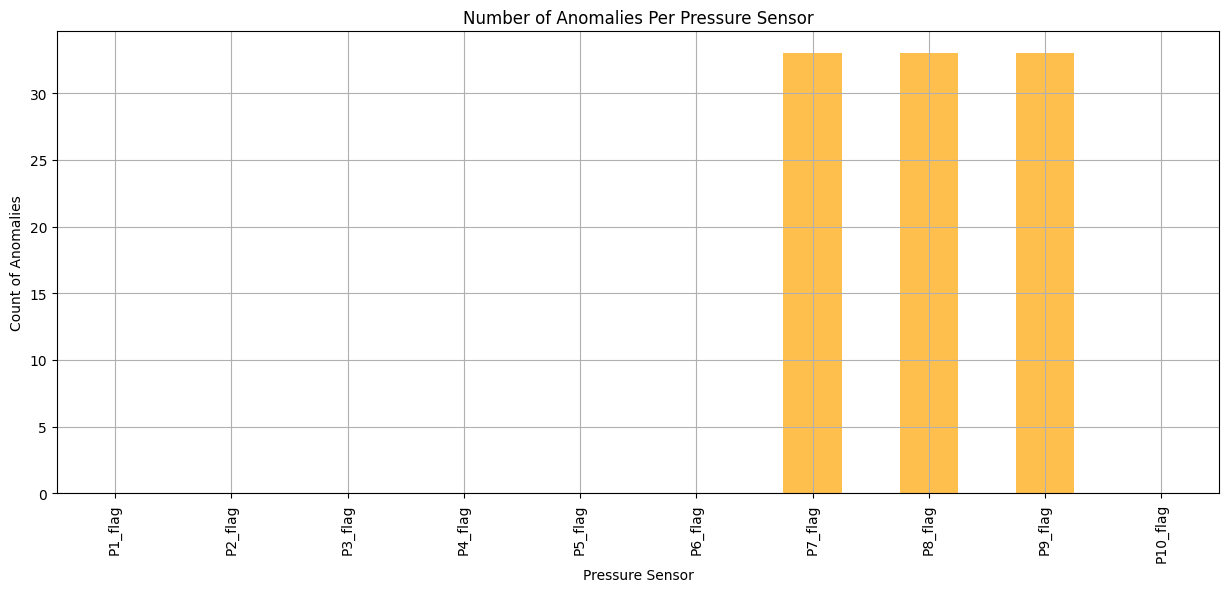

In [63]:
# Count anomalies per pressure sensor flag
sensor_anomaly_counts = sensor_flags.sum()

# Plot the counts for each sensor
plt.figure(figsize=(15, 6))
sensor_anomaly_counts.plot(kind='bar', color='orange', alpha=0.7)
plt.title("Number of Anomalies Per Pressure Sensor")
plt.xlabel("Pressure Sensor")
plt.ylabel("Count of Anomalies")
plt.grid()
plt.show()

2. Flow Rate and Pump Operation During Anomalies

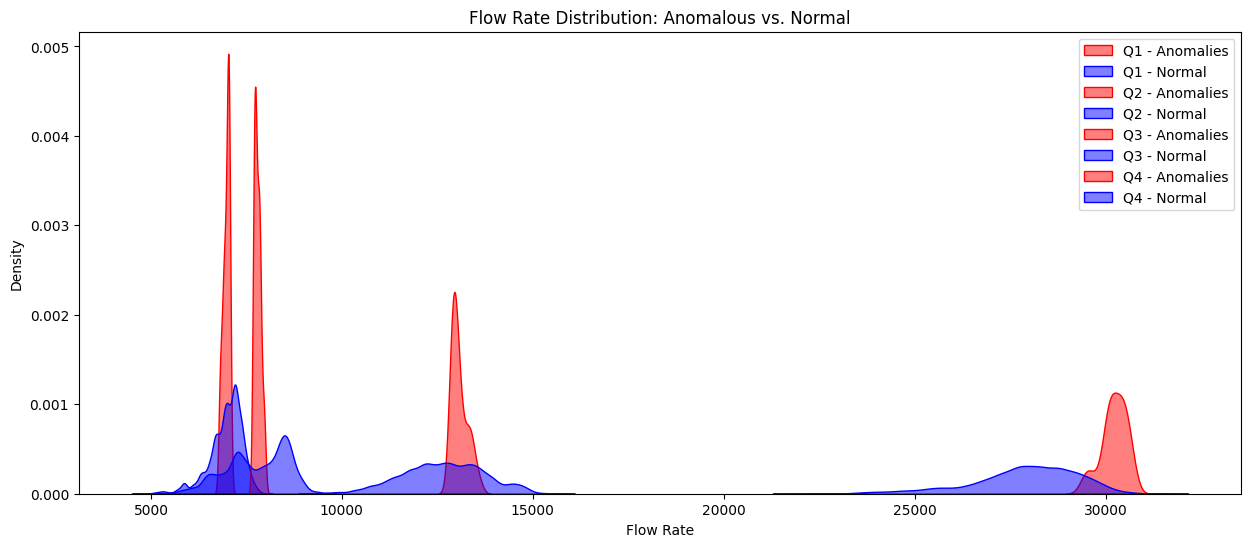

In [64]:
# Compare flow rates during anomalies and normal periods
flow_rate_columns = train_data.filter(regex='^Q').columns.tolist()
flow_anomalies = train_data[train_data['anomaly'] == 1][flow_rate_columns]
flow_normal = train_data[train_data['anomaly'] == 0][flow_rate_columns]

# Plot distribution of flow rates
plt.figure(figsize=(15, 6))
for col in flow_rate_columns:
    sns.kdeplot(flow_anomalies[col], label=f'{col} - Anomalies', fill=True, alpha=0.5, color='red')
    sns.kdeplot(flow_normal[col], label=f'{col} - Normal', fill=True, alpha=0.5, color='blue')
plt.title("Flow Rate Distribution: Anomalous vs. Normal")
plt.xlabel("Flow Rate")
plt.ylabel("Density")
plt.legend()
plt.show()

3. Rolling Pressure Analysis

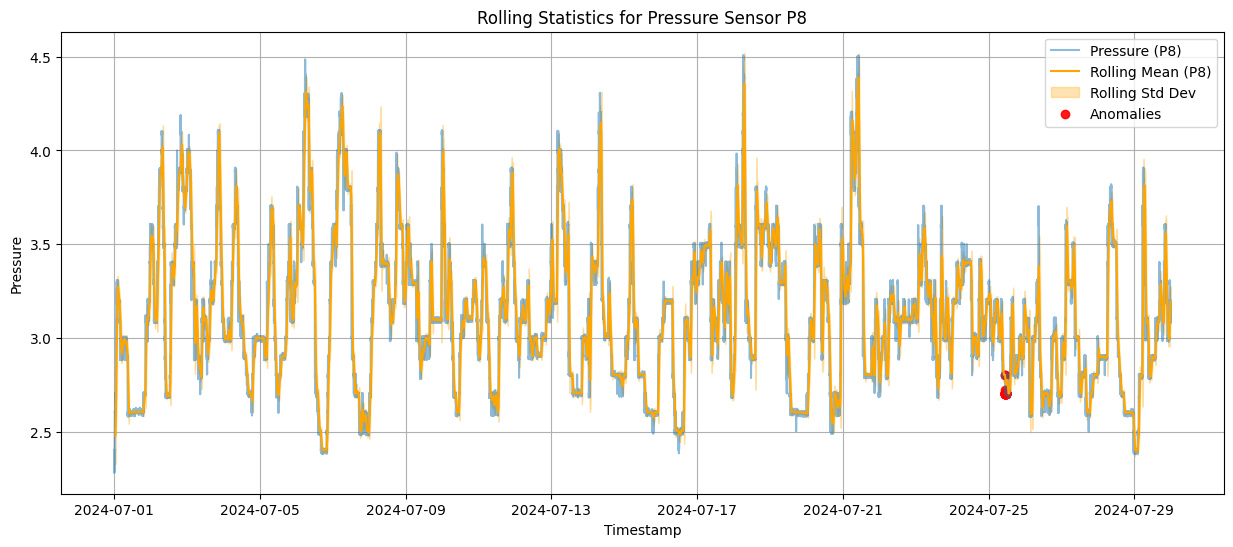

In [65]:
# Calculate rolling averages for a few pressure sensor columns
# Set the pressure sensor column to analyze
pressure_sensor = 'P8'

train_data[f'rolling_mean_{pressure_sensor}'] = train_data[pressure_sensor].rolling(window=60).mean()
train_data[f'rolling_std_{pressure_sensor}'] = train_data[pressure_sensor].rolling(window=60).std()

# Plot rolling statistics for the selected pressure sensor
plt.figure(figsize=(15, 6))
plt.plot(train_data['timestamp'], train_data[pressure_sensor], label=f"Pressure ({pressure_sensor})", alpha=0.5)
plt.plot(train_data['timestamp'], train_data[f'rolling_mean_{pressure_sensor}'], label=f"Rolling Mean ({pressure_sensor})", color="orange")
plt.fill_between(train_data['timestamp'], 
                 train_data[f'rolling_mean_{pressure_sensor}'] - train_data[f'rolling_std_{pressure_sensor}'], 
                 train_data[f'rolling_mean_{pressure_sensor}'] + train_data[f'rolling_std_{pressure_sensor}'], 
                 color="orange", alpha=0.3, label="Rolling Std Dev")
plt.scatter(train_data[train_data['anomaly'] == 1]['timestamp'], 
            train_data[train_data['anomaly'] == 1][pressure_sensor], 
            color='red', label="Anomalies", alpha=0.9)
plt.title(f"Rolling Statistics for Pressure Sensor {pressure_sensor}")
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend()
plt.grid()
plt.show()

4. Hourly Anomaly Analysis

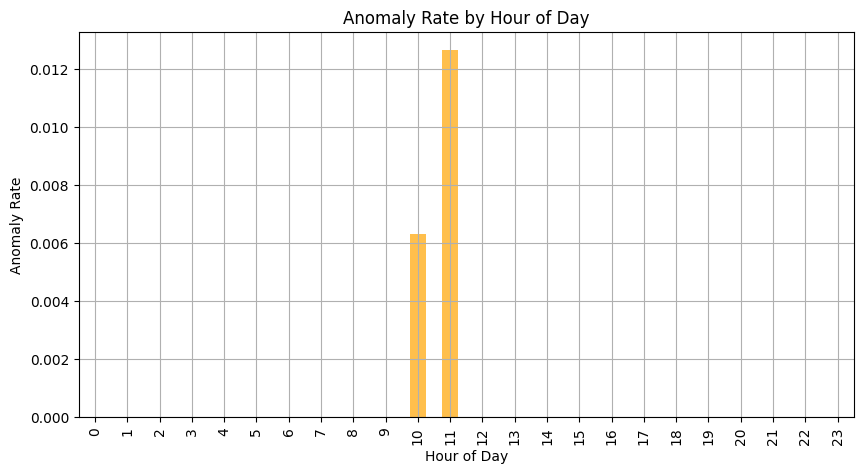

In [66]:
# Extract hour from timestamp
train_data['hour'] = train_data['timestamp'].dt.hour

# Group by hour and calculate anomaly rate
hourly_anomalies = train_data.groupby('hour')['anomaly'].mean()

# Plot anomaly rate by hour
plt.figure(figsize=(10, 5))
hourly_anomalies.plot(kind="bar", color="orange", alpha=0.7)
plt.title("Anomaly Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Anomaly Rate")
plt.grid()
plt.show()

5. Time Series Analysis

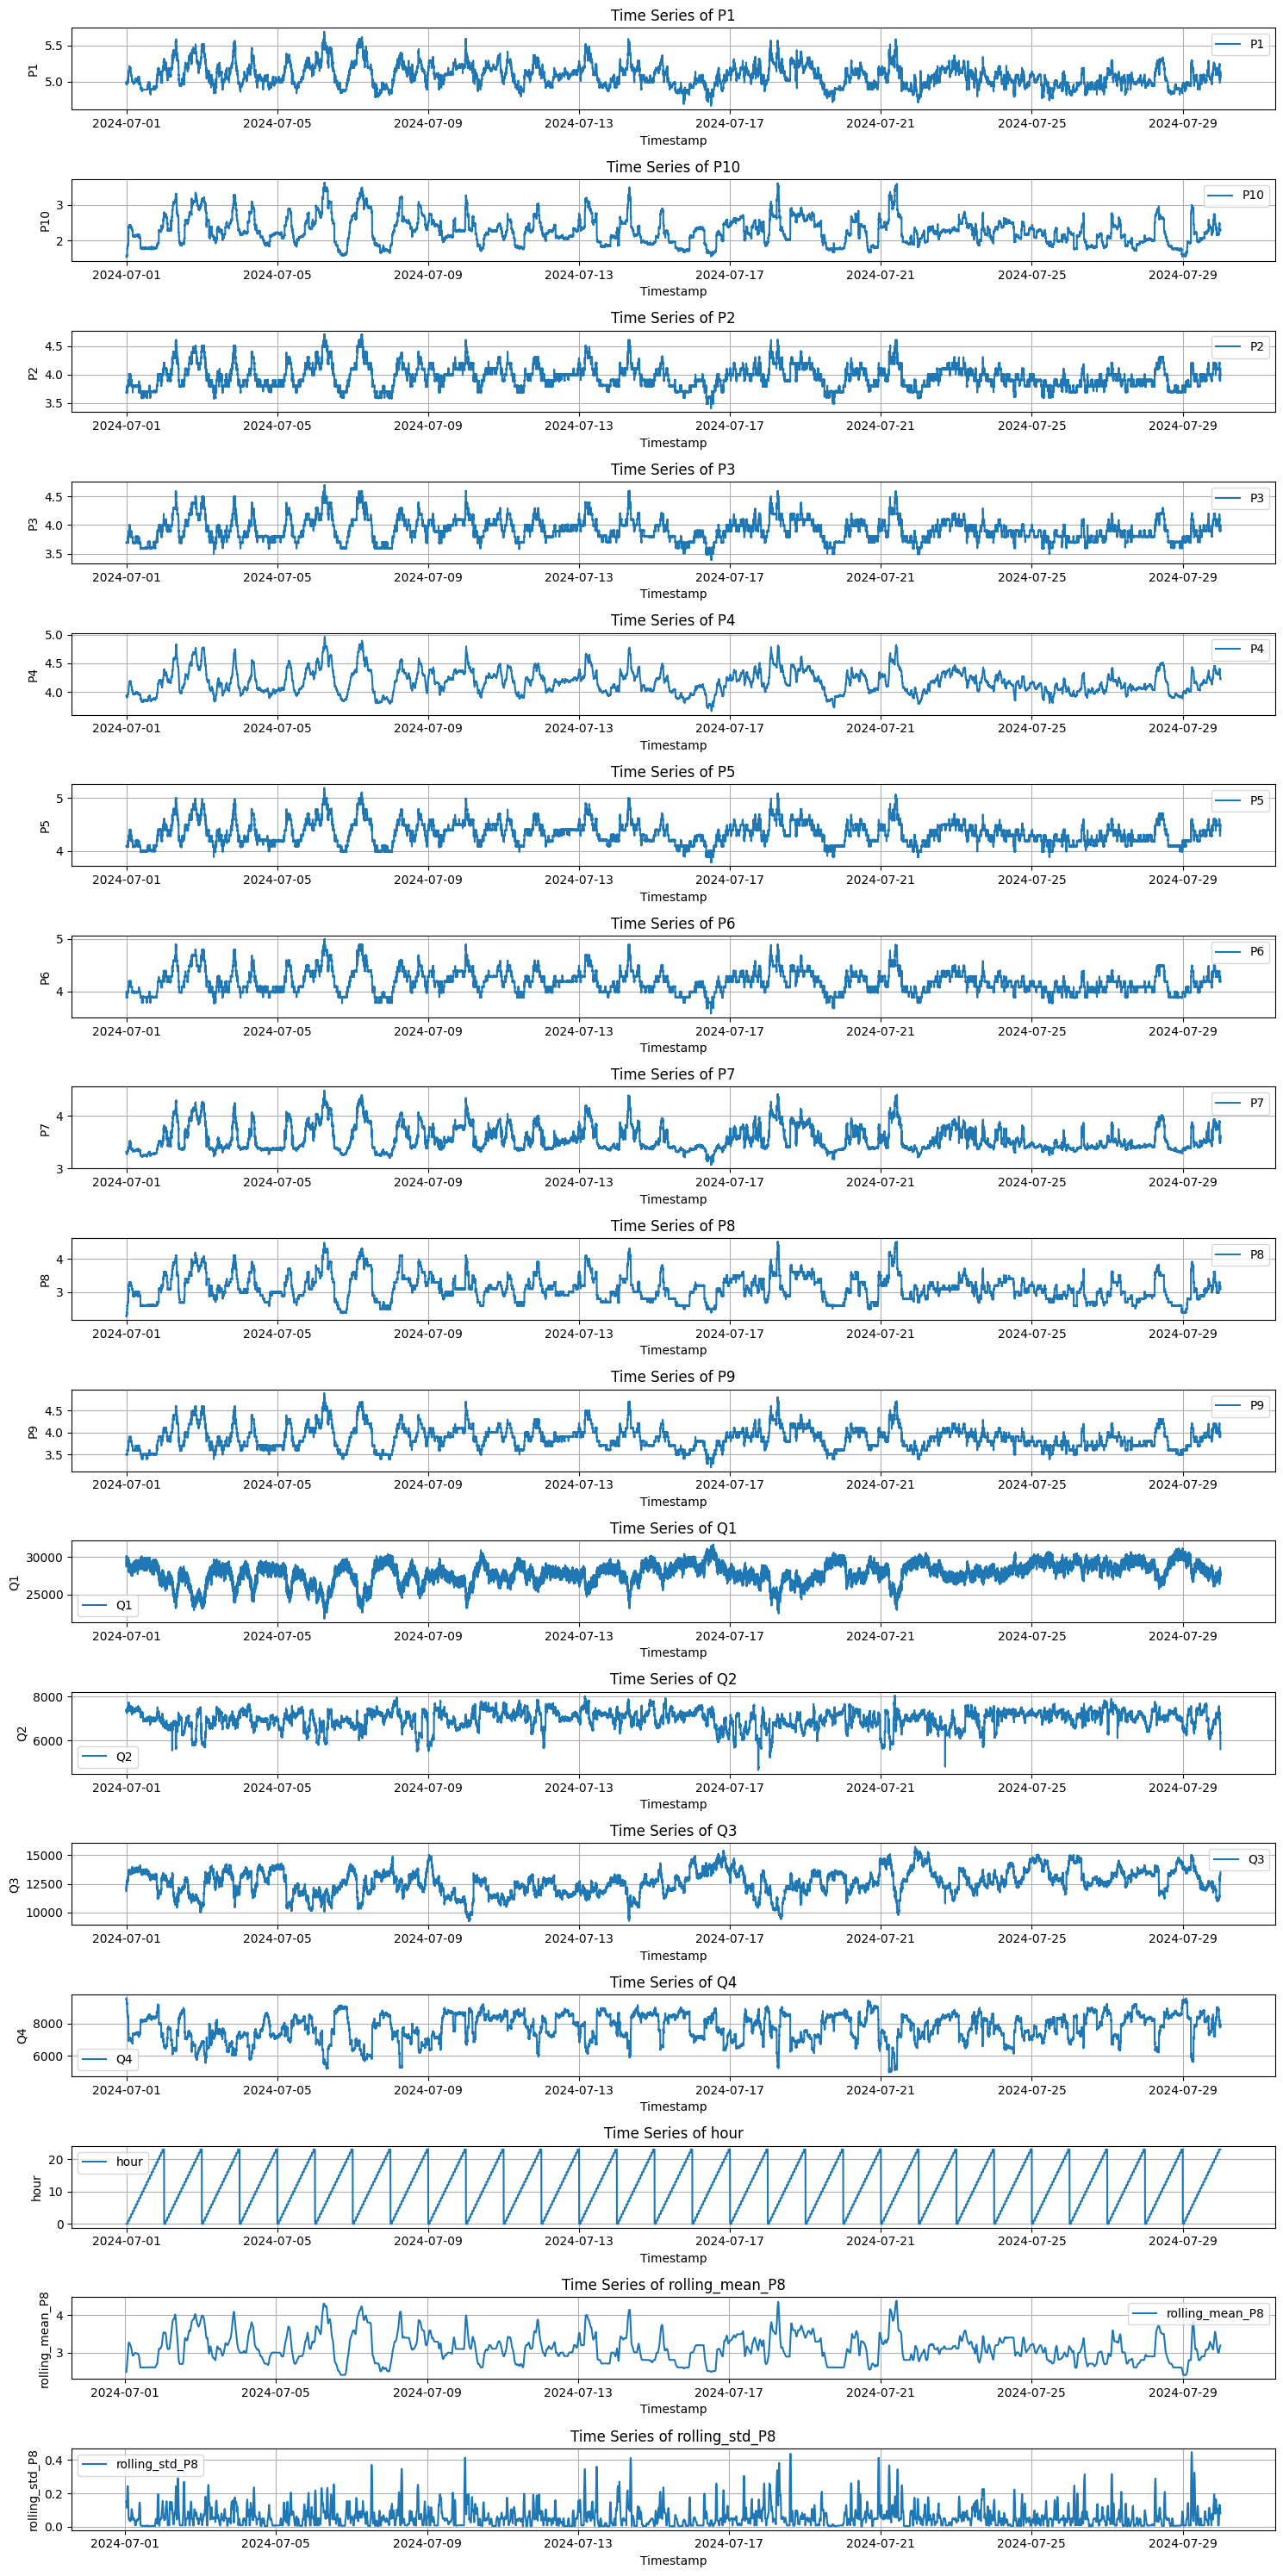

In [67]:
# List of columns to plot
columns_to_plot = train_data.columns.difference(['timestamp', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag', 'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag', 'P10_flag'])

# Plot each column as a time series
plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    plt.plot(train_data['timestamp'], train_data[column], label=column)
    plt.title(f"Time Series of {column}")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()